In [1]:
pip install pyspark

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 317.0/317.0 MB 3.7 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
  Created wheel for pyspark: filename=pyspark-3.5.1-py2.py3-none-any.whl size=317488491 sha256=b6c3acca4cd08904e3a509985e1a60b87143821c0cd25d2fe52aab01660611bf
  Stored in directory: /root/.cache/pip/wheels/80/1d/60/2c256ed38dddce2fdd93be545214a63e02fbd8d74fb0b7f3a6
Successfully built pyspark


In [2]:
from pyspark.sql import SparkSession
from pyspark.sql.functions import col, mean

# Initialize Spark Session
spark = SparkSession.builder.appName("BostonHousing").getOrCreate()

# Load the dataset from csv file
df = spark.read.csv("/content/BostonHousing.csv", sep=",", header = True, inferSchema=True)

In [3]:
# First 5 elements of the dataset
df.show(5)

+-------+----+-----+----+-----+-----+----+------+---+---+-------+------+-----+----+
|   crim|  zn|indus|chas|  nox|   rm| age|   dis|rad|tax|ptratio|     b|lstat|medv|
+-------+----+-----+----+-----+-----+----+------+---+---+-------+------+-----+----+
|0.00632|18.0| 2.31|   0|0.538|6.575|65.2|  4.09|  1|296|   15.3| 396.9| 4.98|24.0|
|0.02731| 0.0| 7.07|   0|0.469|6.421|78.9|4.9671|  2|242|   17.8| 396.9| 9.14|21.6|
|0.02729| 0.0| 7.07|   0|0.469|7.185|61.1|4.9671|  2|242|   17.8|392.83| 4.03|34.7|
|0.03237| 0.0| 2.18|   0|0.458|6.998|45.8|6.0622|  3|222|   18.7|394.63| 2.94|33.4|
|0.06905| 0.0| 2.18|   0|0.458|7.147|54.2|6.0622|  3|222|   18.7| 396.9| 5.33|36.2|
+-------+----+-----+----+-----+-----+----+------+---+---+-------+------+-----+----+
only showing top 5 rows



In [4]:
# Number of observations in the dataset
observation_count = df.count()
print(f"Number of observations: {observation_count}")

Number of observations: 506


In [5]:
# Basic statistics for "medv" column
from pyspark.sql.functions import mean, stddev, min, max

medv_stats = df.select(
    mean('medv').alias('mean_medv'),
    stddev('medv').alias('stddev_medv'),
    min('medv').alias('min_medv'),
    max('medv').alias('max_medv')
).first()

print(f"Mean MEDV: {medv_stats['mean_medv']}")
print(f"Standard Deviation of MEDV: {medv_stats['stddev_medv']}")
print(f"Minimum MEDV: {medv_stats['min_medv']}")
print(f"Maximum MEDV: {medv_stats['max_medv']}")

Mean MEDV: 22.532806324110698
Standard Deviation of MEDV: 9.197104087379815
Minimum MEDV: 5.0
Maximum MEDV: 50.0


In [6]:
# Mean of "rm"
mean_rm = df.select(mean('rm').alias('mean_rm')).first()['mean_rm']
print(f"Mean RM: {mean_rm}")

Mean RM: 6.284634387351787


In [7]:
# Additional imports
from pyspark.sql.functions import corr, count, when
import matplotlib.pyplot as plt

# Correlation matrix for numerical features
correlation_columns = df.columns
correlations = {}
for col1 in correlation_columns:
    for col2 in correlation_columns:
        if col1 != col2:
            corr_value = df.stat.corr(col1, col2)
            correlations[(col1, col2)] = corr_value

In [8]:
# Print some correlations
print("Sample Correlations:")
for key in list(correlations.keys())[:5]:  # Display first 5 for brevity
    print(f"{key[0]} and {key[1]}: {correlations[key]}")

Sample Correlations:
crim and zn: -0.20046921966254744
crim and indus: 0.4065834114062594
crim and chas: -0.05589158222224156
crim and nox: 0.42097171139245537
crim and rm: -0.21924670286251308


In [9]:
# Summary statistics for all columns
df.describe().show()

+-------+------------------+------------------+------------------+------------------+-------------------+------------------+------------------+-----------------+-----------------+------------------+------------------+------------------+------------------+------------------+
|summary|              crim|                zn|             indus|              chas|                nox|                rm|               age|              dis|              rad|               tax|           ptratio|                 b|             lstat|              medv|
+-------+------------------+------------------+------------------+------------------+-------------------+------------------+------------------+-----------------+-----------------+------------------+------------------+------------------+------------------+------------------+
|  count|               506|               506|               506|               506|                506|               506|               506|              506|              

In [10]:
# Counting missing values in each column
missing_values = df.select([count(when(col(c).isNull(), c)).alias(c) for c in df.columns])
missing_values.show()

+----+---+-----+----+---+---+---+---+---+---+-------+---+-----+----+
|crim| zn|indus|chas|nox| rm|age|dis|rad|tax|ptratio|  b|lstat|medv|
+----+---+-----+----+---+---+---+---+---+---+-------+---+-----+----+
|   0|  0|    0|   0|  0|  0|  0|  0|  0|  0|      0|  0|    0|   0|
+----+---+-----+----+---+---+---+---+---+---+-------+---+-----+----+



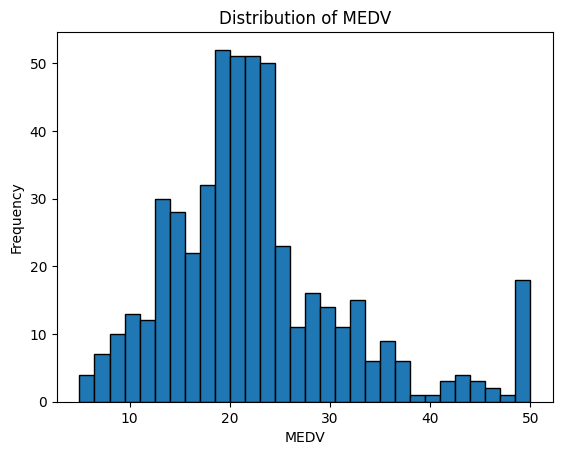

In [11]:
# Distribution of 'medv' (Median value of owner-occupied homes)
medv_data = df.select('medv').rdd.flatMap(lambda x: x).collect()
plt.hist(medv_data, bins=30, edgecolor='k')
plt.xlabel('MEDV')
plt.ylabel('Frequency')
plt.title('Distribution of MEDV')
plt.show()

In [13]:
# Calculating the average 'medv' by 'chas' (Charles River dummy variable)
chas_medv_avg = df.groupBy('chas').agg(mean('medv').alias('avg_medv')).show()

+----+------------------+
|chas|          avg_medv|
+----+------------------+
|   1|             28.44|
|   0|22.093842887473482|
+----+------------------+



In [14]:
# Calculate average 'medv' by 'lstat' (Percentage of lower status of the population)
df.groupBy('lstat').agg(mean('medv').alias('avg_medv')).orderBy('lstat').show()

+-----+--------+
|lstat|avg_medv|
+-----+--------+
| 1.73|    50.0|
| 1.92|    50.0|
| 1.98|    34.9|
| 2.47|    41.7|
| 2.87|    36.4|
| 2.88|    50.0|
| 2.94|    33.4|
| 2.96|    50.0|
| 2.97|    50.0|
| 2.98|    32.0|
| 3.01|    46.0|
| 3.11|   43.15|
| 3.13|    37.6|
| 3.16|   46.75|
| 3.26|    50.0|
| 3.32|    50.0|
| 3.33|    28.5|
| 3.53|    31.0|
| 3.54|    42.8|
| 3.56|    37.3|
+-----+--------+
only showing top 20 rows



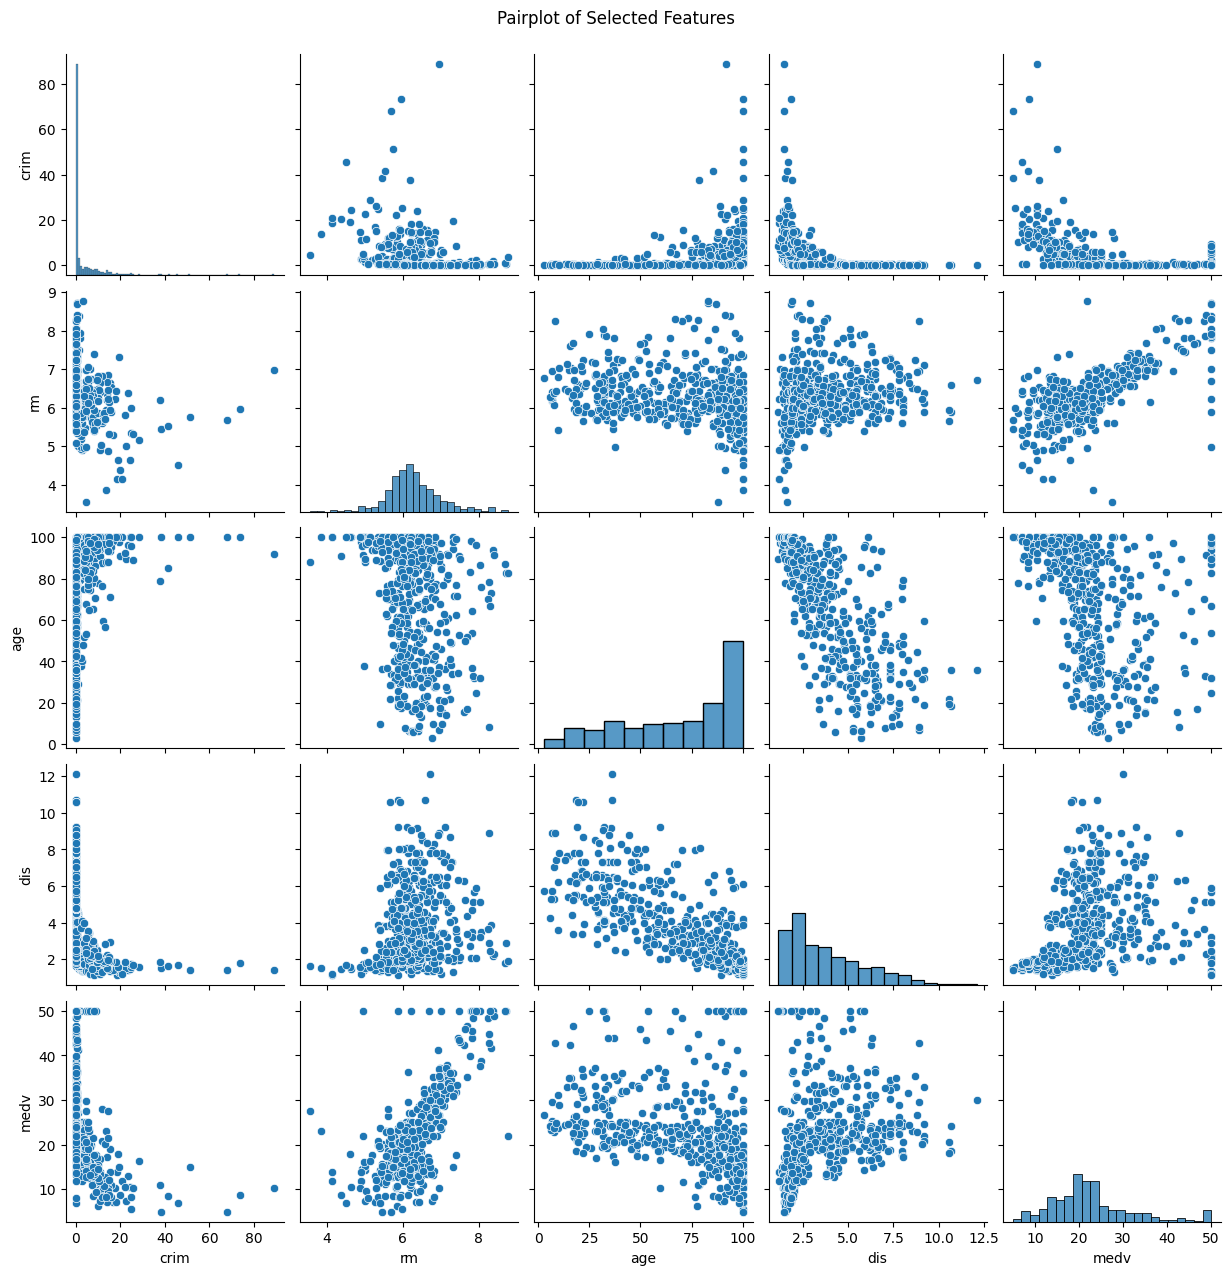

In [16]:
# Additional imports for visualization
import seaborn as sns
import pandas as pd
import numpy as np

# Convert Spark DataFrame to Pandas DataFrame for visualization
df_pandas = df.toPandas()

# Pairplot for a subset of features
sns.pairplot(df_pandas[['crim', 'rm', 'age', 'dis', 'medv']])
plt.suptitle('Pairplot of Selected Features', y=1.02)
plt.show()

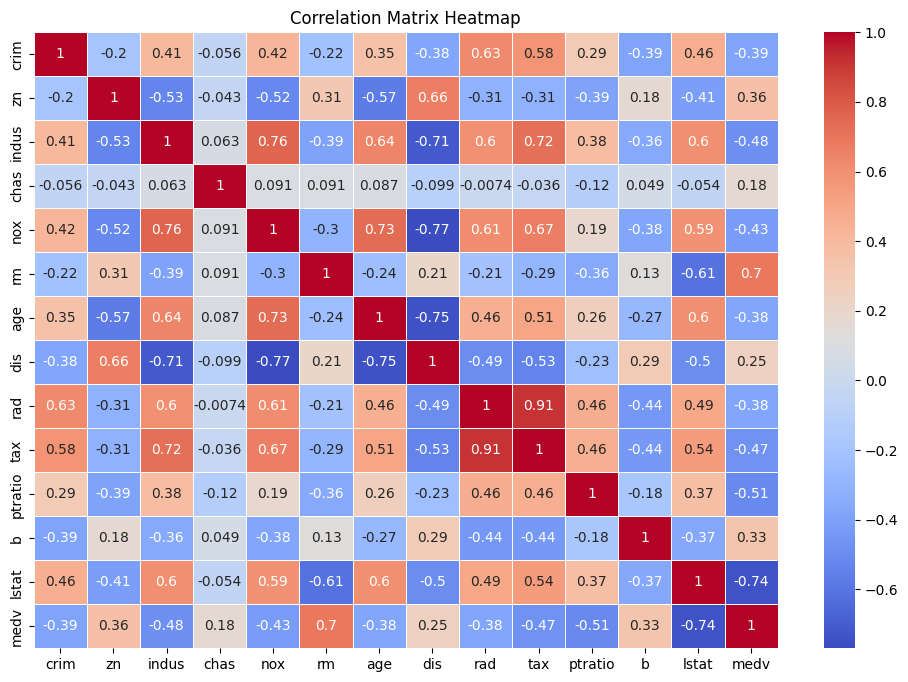

In [17]:
# Heatmap of the correlation matrix
corr_matrix = df_pandas.corr()
plt.figure(figsize=(12, 8))
sns.heatmap(corr_matrix, annot=True, cmap='coolwarm', linewidths=0.5)
plt.title('Correlation Matrix Heatmap')
plt.show()

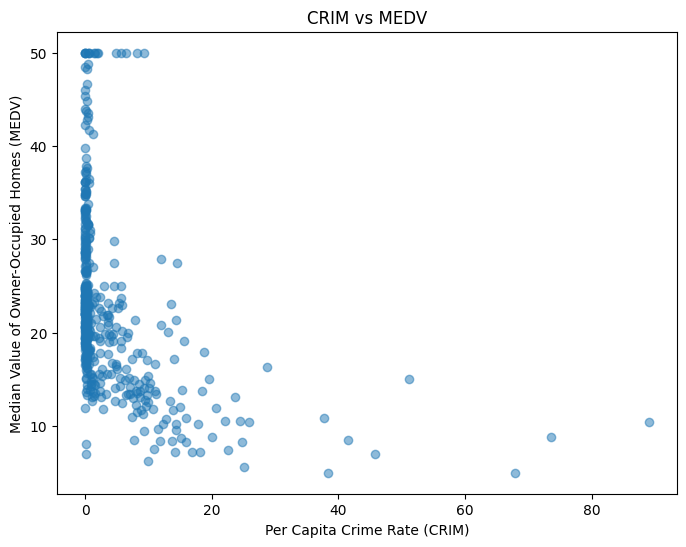

In [18]:
# Scatter plot for 'crim' vs 'medv'
plt.figure(figsize=(8, 6))
plt.scatter(df_pandas['crim'], df_pandas['medv'], alpha=0.5)
plt.xlabel('Per Capita Crime Rate (CRIM)')
plt.ylabel('Median Value of Owner-Occupied Homes (MEDV)')
plt.title('CRIM vs MEDV')
plt.show()

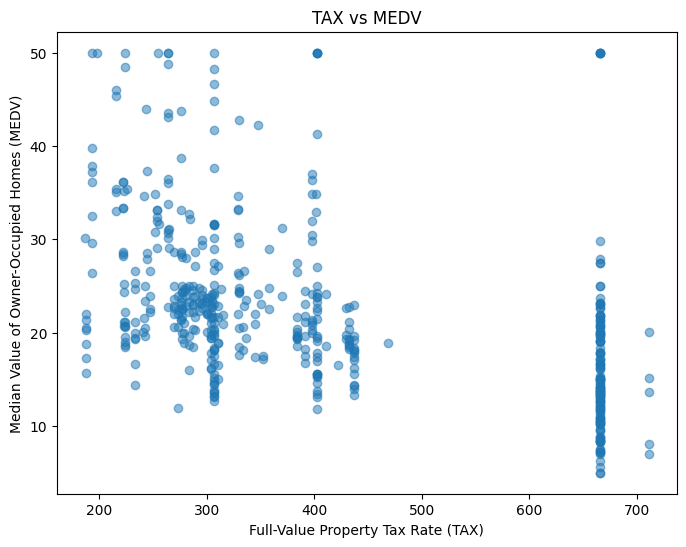

In [19]:
# Scatter plot for 'tax' vs 'medv'
plt.figure(figsize=(8, 6))
plt.scatter(df_pandas['tax'], df_pandas['medv'], alpha=0.5)
plt.xlabel('Full-Value Property Tax Rate (TAX)')
plt.ylabel('Median Value of Owner-Occupied Homes (MEDV)')
plt.title('TAX vs MEDV')
plt.show()

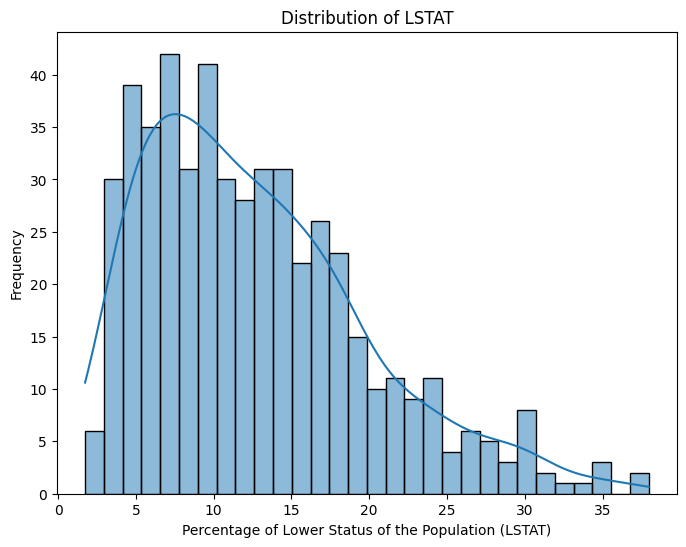

In [20]:
# Distribution plot for 'lstat'
plt.figure(figsize=(8, 6))
sns.histplot(df_pandas['lstat'], bins=30, kde=True)
plt.xlabel('Percentage of Lower Status of the Population (LSTAT)')
plt.ylabel('Frequency')
plt.title('Distribution of LSTAT')
plt.show()

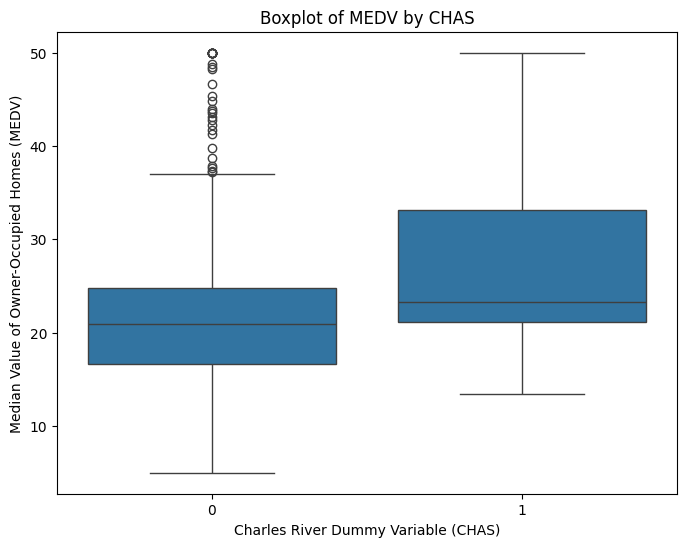

In [21]:
# Boxplot for 'medv' by 'chas'
plt.figure(figsize=(8, 6))
sns.boxplot(x='chas', y='medv', data=df_pandas)
plt.xlabel('Charles River Dummy Variable (CHAS)')
plt.ylabel('Median Value of Owner-Occupied Homes (MEDV)')
plt.title('Boxplot of MEDV by CHAS')
plt.show()

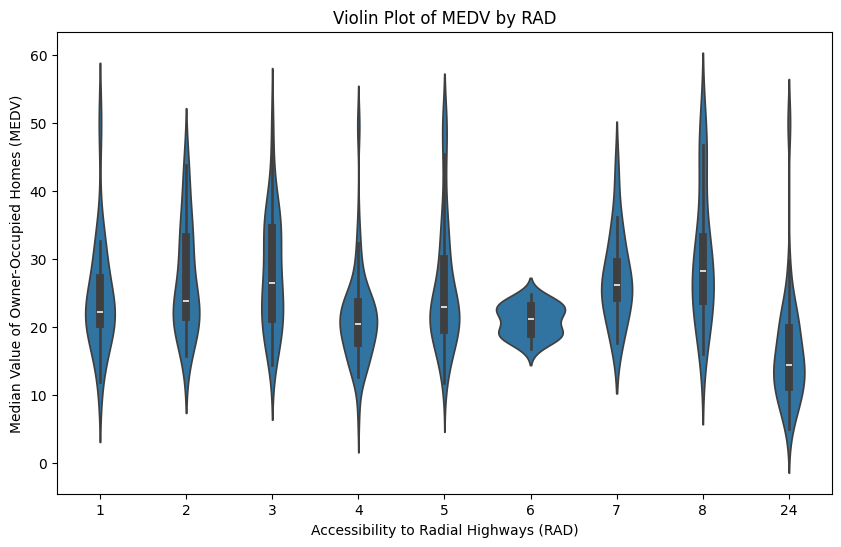

In [22]:
# Violin plot for 'medv' by 'rad' (index of accessibility to radial highways)
plt.figure(figsize=(10, 6))
sns.violinplot(x='rad', y='medv', data=df_pandas)
plt.xlabel('Accessibility to Radial Highways (RAD)')
plt.ylabel('Median Value of Owner-Occupied Homes (MEDV)')
plt.title('Violin Plot of MEDV by RAD')
plt.show()